In [21]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler

def knearestneighbors(df, k, attributes):

    # Select features and target
    X = df[attributes].values
    y = df['disease'].values
    
    # Initialize Nearest Neighbors model
    nn = NearestNeighbors(n_neighbors=k, metric='euclidean', algorithm='auto')

    # Track precision, recall, and F1 scores for 10 iterations
    test_sizes = [0.1, 0.15, 0.2, 0.25, 0.3, 0.33, 0.4, 0.45, 0.5, 0.6]
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    for _ in range(10):  # 10 iterations
        # Randomly choose a test size and perform train-test split
        test_size = random.choice(test_sizes)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

        # Fit the Nearest Neighbors model on the training set
        nn.fit(X_train)

        # Store predictions for the test set
        y_pred = []
        for test_point in X_test:
            distances, indices = nn.kneighbors([test_point])
            nbrs = df.iloc[indices[0]]

            # Get the majority class among the k-nearest neighbors
            healthy = nbrs[nbrs['disease'] == 0].count().disease
            sick = nbrs[nbrs['disease'] == 1].count().disease
            predict = 0 if (healthy > sick) else 1
            y_pred.append(predict)

        # Evaluate the predictions: precision, recall, F1 score
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)


    for i, precision in enumerate(precision_scores):
        print(f"Iteration: {i + 1}")  # Start iteration count from 1 instead of 0
        print(f"Precision Score: {precision_scores[i]}")
        print(f"Recall Score: {recall_scores[i]}")
        print(f"F1 Score: {f1_scores[i]}")
        print()
    print("Mean F1 Score:", sum(f1_scores) / len(f1_scores))


## Part I

First, we needed to determine the optimal value of k for this dataset. We did this using the elbow method.

In [22]:
def get_scores(k, df):
  # Use knn on age. First create a nearest neighbors object.
  nn = NearestNeighbors(n_neighbors=k, metric='euclidean', algorithm='auto')

  # This builds an index data structure under the hood for query performance
  X = df[['age_s', 'trestbps_s']].values
  fit = nn.fit(X)

  # Get random patients to test on
  n = 50
  patients = df.sample(n)
  patientsX = patients[['age_s','trestbps_s']].values
  patientsy = patients[['disease']].values
  # display(patients)

  # Find the k nearest neighbors to the patient.
  distances, indices = fit.kneighbors(patientsX)

  y_pred = []
  for i in range(n):
      nbrs = df.iloc[indices[i]]
      # Drop the patient of interest
      nbrs = nbrs.drop(patients.index[i], errors='ignore')

      healthy = nbrs[nbrs.disease == 0].count().disease
      sick = nbrs[nbrs.disease == 1].count().disease
      predict = 0 if (healthy > sick) else 1
      y_pred.append(predict)

  return precision_recall_fscore_support(patientsy, y_pred, labels=[1])

def determine_k(file):
  df = pd.read_csv(file)
  df['disease'] = df.num.apply(lambda x: min(x,1))
  df['age_s'] = (df.age - df.age.mean())/df.age.std()
  df['trestbps_s'] = (df.trestbps - df.trestbps.mean())/df.trestbps.std()

  kvals = range(2, 250)
  scores = [get_scores(k, df) for k in kvals]
  scores = [(p[0], r[0], f[0], s[0]) for (p,r,f,s) in scores]
  scores = list(zip(*scores))

  k_options = pd.DataFrame(
    {'f score': scores[2],
     'k': kvals
    })

  k_options = k_options.sort_values(by='f score', ascending=False)

  return (kvals, scores[2], k_options)

In [23]:
result = determine_k('cleveland.csv')
result[2].head()

/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,f score,k
47,0.819672,49
36,0.754717,38
119,0.740741,121
105,0.727273,107
137,0.716981,139


Text(0, 0.5, 'f score')

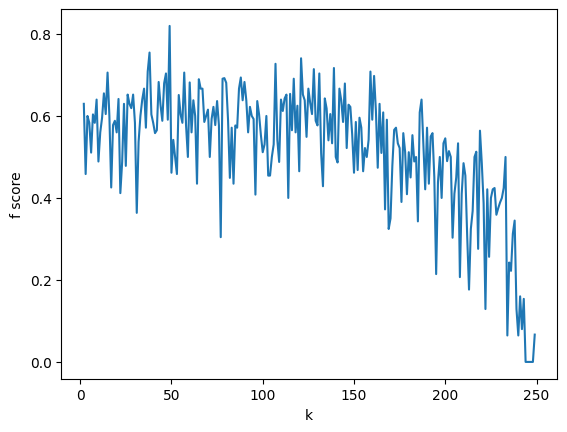

In [24]:
plt.plot(result[0], result[1])
plt.xlabel('k')
plt.ylabel('f score')

Now, we need to determine the optimal set of attributes to use.

(TODO)

Now that we've determined the optimal k and set of attributes, we can use the k nearest neighbors method to predict whether patients have heart disease. We'll also evaluate our model.

In [38]:

df = pd.read_csv('cleveland.csv')
df = df.rename({'num': 'disease'}, axis=1)
df['disease'] = df['disease'].apply(lambda x: min(x, 1))
columns_to_standardize = ['age', 'trestbps', 'chol', 'thalach']
scaler = StandardScaler()
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
knearestneighbors(df, 10, ['age', 'trestbps', 'chol', 'thalach'])

Iteration: 1
Precision Score: 0.5942028985507246
Recall Score: 0.640625
F1 Score: 0.6165413533834586

Iteration: 2
Precision Score: 0.5833333333333334
Recall Score: 0.56
F1 Score: 0.5714285714285714

Iteration: 3
Precision Score: 0.5
Recall Score: 0.40625
F1 Score: 0.4482758620689655

Iteration: 4
Precision Score: 0.5
Recall Score: 0.5581395348837209
F1 Score: 0.5274725274725275

Iteration: 5
Precision Score: 0.4
Recall Score: 0.5301204819277109
F1 Score: 0.45595854922279794

Iteration: 6
Precision Score: 0.5833333333333334
Recall Score: 0.5675675675675675
F1 Score: 0.5753424657534246

Iteration: 7
Precision Score: 0.46296296296296297
Recall Score: 0.5102040816326531
F1 Score: 0.4854368932038835

Iteration: 8
Precision Score: 0.5
Recall Score: 0.40625
F1 Score: 0.4482758620689655

Iteration: 9
Precision Score: 0.5833333333333334
Recall Score: 0.56
F1 Score: 0.5714285714285714

Iteration: 10
Precision Score: 0.45588235294117646
Recall Score: 0.4305555555555556
F1 Score: 0.44285714285714

## Part II

Now, we will repeat the same process for our second data set. This data set contains information about urls and whether they are known to be phishing or legitimate. 

Source: https://archive.ics.uci.edu/dataset/967/phiusiil+phishing+url+dataset